### The problem

Classify the pair of the images from UAV and Satellite. If they are clearly the same - return 1, 0 otherwise

The tricky part: images are taken from a video stream, so it is hard problem even for a human eye.

It means that we have to concentrate on details a lot.

Since i don't have any data provided, i need to start looking at pretrained models and classic CV algorithms.


#### Similar problems

If the data domain is considered, the main topics of research are:

- UAV self-localization [1], [2], [3]
- Object detection in UAV images. [4]
- Image retrieval

Another problems, which were considered:

- Image matching. Normally this is more about feature mapping in a cross-view mode. Where the pictures are represented from very different angles 



In [2]:
from utils import resolution_distributions, display_images

for path_ in ('../data/test/sat_images', '../data/test/uav_images', '../data/test/false_sat_images'):
    print(resolution_distributions(path_))

{'5472x3730': 387, '5472x3568': 1, '5472x3979': 25, '5472x3908': 12}
{'5472x3648': 425}
{'5472x3730': 5643, '5472x3908': 90, '5472x3979': 248, '5472x4169': 4}


#### Dataset

##### Train

I don't have any training data provided

##### Test

The test positive pairs are ready. I need to complete it with negatives.

1. Number of examples:
- Number of positive pairs: 425
- Number of negative examples from the Satelite: 5985

2. Resolutions
- False sat images distribution

    {'5472x3730': 5643, '5472x3979': 248, '5472x3908': 90, '5472x4169': 4}

- sat_images distribution

    {'5472x3730': 387, '5472x3979': 25, '5472x3908': 12, '5472x3568': 1}
    
    ! Note that satelite images are significantly smaller (on disk) and lower quality

- uav_images distribution

    {'5472x3648': 425}



##### Making a test set

After taking a look at the images i decided to create different negative examples in terms of the complexity.

The most complex negative pair to distinguish are the positive shifted by one. It means they will be hard to distinguish

Next level is the same technique, but shifted by two

And the last (easiest fraction) is made by random pairing with totally different images (false_sat_images)

In [8]:
import os
import pandas as pd
import numpy as np

from pathlib import Path

data_path = Path("../data") / "test"
uav_images = data_path / "uav_images"
sat_images = data_path / "sat_images"
false_images = data_path / "false_sat_images"

df = pd.DataFrame(columns=["uav_image", "sat_image", "similar", "complexity"])

basenames = sorted(os.listdir(uav_images))
false_image_names = sorted(os.listdir(false_images))

df[["uav_image", "sat_image"]] = [[uav_images / b, sat_images / b] for b in basenames]
df["similar"] = True
df["complexity"] = 0

df2 = df.copy()
df2['sat_image'] = df2['sat_image'].shift(-1).fillna(df2['sat_image'].values[-2:-1][0])
df2['similar'] = False
df2['complexity'] = 3

df3 = df.copy()
df3['sat_image'] = df3['sat_image'].shift(-2, fill_value="../data/test/sat_images/DJI_0688.JPG")
df3['similar'] = False
df3['complexity'] = 2

df4 = df.copy()
df4["sat_image"] = [false_images / b for b in false_image_names[slice(0, df.shape[0])]]
df4['similar'] = False
df4['complexity'] = 1

final_df = pd.concat([df, df2, df3, df4], ignore_index=True)
# let's check if the csv is correct
final_df.iloc[::425, :]


,uav_image,sat_image,similar,complexity
0,../data/test/uav_images/DJI_0267.JPG,../data/test/sat_images/DJI_0267.JPG,True,0
425,../data/test/uav_images/DJI_0267.JPG,../data/test/sat_images/DJI_0268.JPG,False,3
850,../data/test/uav_images/DJI_0267.JPG,../data/test/sat_images/DJI_0269.JPG,False,2
1275,../data/test/uav_images/DJI_0267.JPG,../data/test/false_sat_images/(38.571844051845...,False,1


In [10]:
final_df.to_csv(data_path / "pairs.csv", index=False)

#### Solution candidates

Critical moments to consider:
- **Time for development**
- Inference speed



##### Thoughts

Training is not an option because:

- there is no training set either labeled or not
- it consumes quite a lot of time to create one


So the next step is to come up with a **feature extractor** (to create a **representations**) and measure the similarities

Standard feature extractors like SIFT, FAST etc work not too good primarily because the difference in contrast, brightness (sunny satelite images) and overall image quality. Plus, the pictures are taken in different time, so there are a lot of temporal differences (cars displacement, trees, repaired roofs)

The examples below:

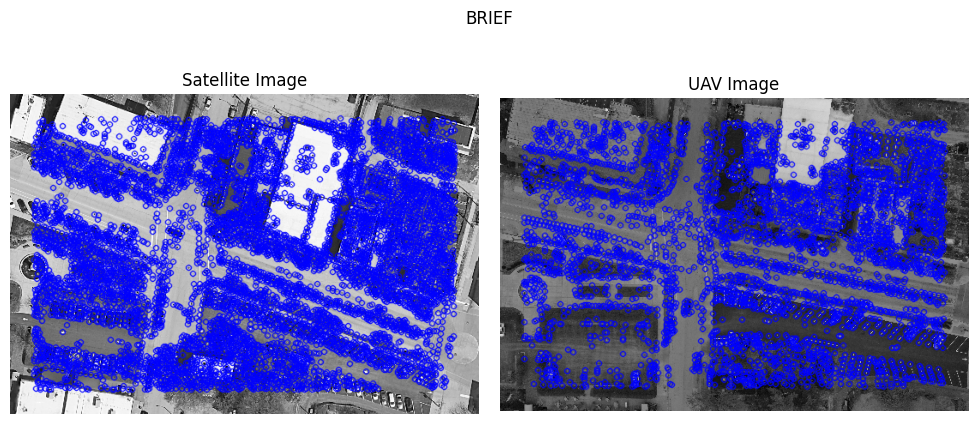

In [2]:
from utils import display_images

display_images(
    "classic_cv/brief/brief_true_sat.png", 
    "classic_cv/brief/brief_true_uav.png",
    "BRIEF"
)


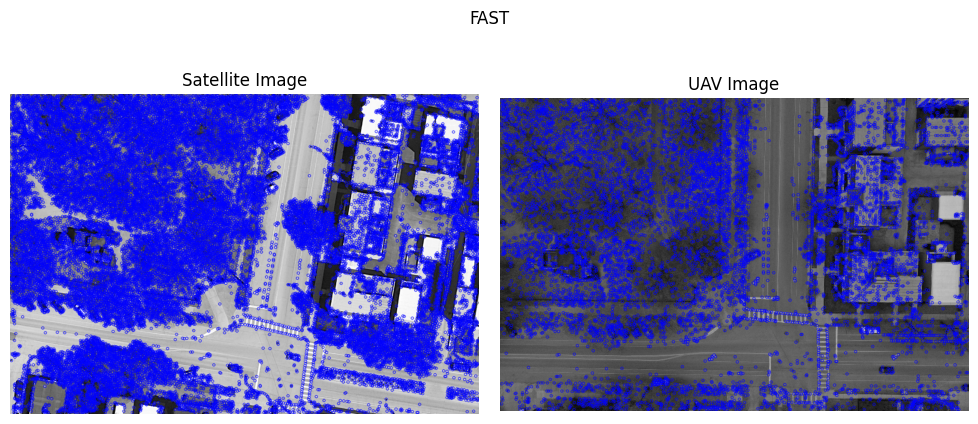

In [3]:
display_images(
    "classic_cv/fast/fast_true_sat.png", 
    "classic_cv/fast/fast_true_uav.png",
    "FAST"
)

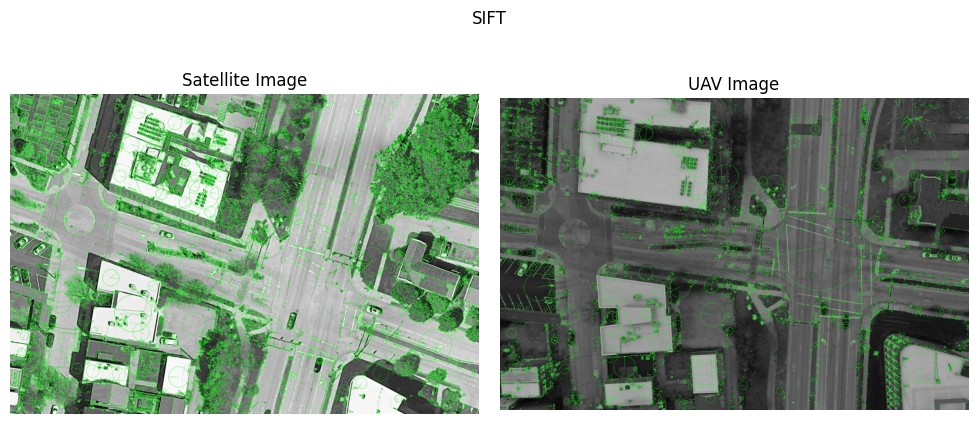

In [4]:
display_images(
    "classic_cv/sift/sift_keypoints_half.jpg", 
    "classic_cv/sift/sift_keypoints_uav_half.jpg",
    "SIFT"
)

#### CV results
It turns out that it might be enough to look only at the center of the image and compare the patches.

Let's try the classic template matching.

**The idea is to get the patch from a center of one image and try to find it on another image. If the hot point is something far from the center, we consider the images different. If close - similar.**

Code may be found in ```code/classic_cv/template_matching/skimge.py```

Let's take a look at results:

In [57]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix


def print_metrics(df):
    tn, fp, fn, tp = confusion_matrix(df["similar"], df["pred"]).ravel()
    print("F1:", f1_score(df["similar"], df["pred"]))
    print("Acc:", accuracy_score(df["similar"], df["pred"]))
    print("Precision:", precision_score(df["similar"], df["pred"]))
    print("Recall:", recall_score(df["similar"], df["pred"]))
    print(f"TP: {tp}", f"TN: {tn}", f"FP: {fp}", f"FN: {fn}", sep="\n")


def fp_rate(g):
    tn, fp, fn, tp = confusion_matrix(g["similar"], g["pred"]).ravel()
    return fp / (fp + tn + fn + tp)


df = pd.read_csv("../data/test/pairs_with_results.csv")
df.groupby("complexity")["mh_dst_128_f02"].quantile(0.7)

complexity
0    399.6
1    554.4
2    416.4
3    406.6
Name: mh_dst_128_f02, dtype: float64

In [58]:
df["pred"] = df["mh_dst_128_f02"] < 399.6
print_metrics(df)

df.groupby("complexity").apply(lambda x: fp_rate(x))

F1: 0.4016227180527383
Acc: 0.47941176470588237
Precision: 0.28178368121442127
Recall: 0.6988235294117647
TP: 297
TN: 518
FP: 757
FN: 128


complexity
0    0.000000
1    0.421176
2    0.672941
3    0.687059
dtype: float64

#### Conclusions on template matching

It is bad. A lot of false positives tells that it is not a robust algorithm at all.

Next steps here:
- run the same cross-correlaion filters on 3 channels
- add image pyramid

However, it is probably not a good idea to make anything with it.

The same could be done with a similar idea of image retrieval with better backbone like resnet or ViT


### ResNet and Absolute error

In order to check how the pretrained feature extractor would deal with such specific case, i will make the following:

- Get the images, resize them and center crop to 1120 px (keep the ratio). It simply means that i can make 5x5 patches of 224x224 px
- Get the representations
- Calculate the absolute error between features in corresponding regions
- (Try 2 architectures to chheck if the complexity is crutial)


The code can be found here ```code/simple_resnet_knn.py```

Let's take a look at results:

In [59]:
df.groupby("complexity")["resnet_18_manh"].quantile(0.7)

complexity
0    7757.366797
1    9105.372461
2    8279.012109
3    8061.763086
Name: resnet_18_manh, dtype: float64

In [60]:
df["pred"] = df["resnet_18_manh"] < 7757
print_metrics(df)

df.groupby("complexity").apply(lambda x: fp_rate(x))

F1: 0.6477024070021881
Acc: 0.8105882352941176
Precision: 0.6053169734151329
Recall: 0.6964705882352941
TP: 296
TN: 1082
FP: 193
FN: 129


complexity
0    0.000000
1    0.014118
2    0.131765
3    0.308235
dtype: float64

In [61]:
df.groupby("complexity")["resnet_34_manh"].quantile(0.7)

complexity
0    8622.132031
1    9941.583594
2    9139.627734
3    8904.173828
Name: resnet_34_manh, dtype: float64

In [62]:
df["pred"] = df["resnet_34_manh"] < 8622
print_metrics(df)

df.groupby("complexity").apply(lambda x: fp_rate(x))

F1: 0.6168224299065421
Acc: 0.7829411764705883
Precision: 0.5520446096654275
Recall: 0.6988235294117647
TP: 297
TN: 1034
FP: 241
FN: 128


complexity
0    0.000000
1    0.011765
2    0.195294
3    0.360000
dtype: float64

#### Conclusions on ResNet

Clearly, it is a lot better. Precision at recall is (0.6 | 0.7)
However, the more complex feature extractor leads to worse results.

It is not a solution, rather a baseline.

#### Next steps

I would take a look at the absoolute errors in center of the image

Then i would probably try to go with combined approach from the [1] and what i did with template matching.

Another vector is to make patches of the false sat images, change the gamma, add noise, randomly rotate a bit and fine tune the extractor on siamese realm.


### Resources and links

1. Dai, M., Zheng, E., Feng, Z., Chen, J., & Yang, W. (2022). Finding Point with Image: A Simple and Efficient Method for UAV Self-Localization.

2. Ye, J., Fu, C., Lin, F., Ding, F., An, S., & Lu, G. (2021). Multi-Regularized Correlation Filter for UAV Tracking and Self-Localization. IEEE Transactions on Industrial Electronics, 69, 6004-6014.

3. Dai, M., Zheng, E., Feng, Z., Qi, L., Zhuang, J., & Yang, W. (2022). Vision-Based UAV Self-Positioning in Low-Altitude Urban Environments. IEEE Transactions on Image Processing, 33, 493-508.

4. Tan, S., Duan, Z., & Pu, L. (2024). Multi-scale object detection in UAV images based on adaptive feature fusion. PLOS ONE, 19.
